This workbook is a continuation of my exploration of loan data from Lending Club. I assume that I have filtered loans originated in 2017 only. It is entirely possible to include all loans originated from 2007 to 2017. However, I feel that loans in 2017 are representative of the whole population and should be a higher quality due to the continuous improvement in data management and governance from Lending Club. Moreover, using only data from 2017, which is a fraction of total loans, will allow much faster computation. 

In this workbook, I explore the data by:
* Exploring the distribution of annual income across different professions
* Exploring the Good and Bad loans depending on FICO scores at origination 
* Building a simple model to predict whether a loan is Good or Bad.

A Good loan is defined as a loan that has paid off completely or an in Grace Period. However, further iteration may refine further.

In [1]:
%matplotlib inline
import os 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
import seaborn as sns

accepted_original = pd.read_csv('accepted2017.csv', encoding = "ISO-8859-1")
accepted = accepted_original

I decide to drop several columns because they are a linear combination of others, or they contain too little information.

As for Zip Code, we only have the first 3 number so this feature is not helpful.

In [2]:
# Drop columns
accepted = accepted.drop(['title', 'funded_amnt'], axis = 1)
# accepted = accepted.drop(['title', 'funded_amnt', 'funded_amnt_inv'], axis = 1)

# linear combination of other columns
accepted = accepted.drop(['out_prncp_inv','total_rec_prncp','total_pymnt_inv'], axis = 1)

accepted = accepted.drop(["fico_range_low", "last_fico_range_low",
                         'avg_cur_bal',
                         'addr_state', 'initial_list_status', 'pymnt_plan',
                         'application_type', 'hardship_flag', 'disbursement_method',
                          'debt_settlement_flag','sub_grade',
                         'zip_code', 'id','policy_code','tax_liens', 'tax_liens'], axis = 1)


I transform a few variables into the date type for easier analysis later. I also transform the term from '36 months' or '60 months' into '36' or '60' as strings.

In [3]:
# Transform variables
accepted['issue_d'] = pd.to_datetime(accepted.issue_d)
accepted['last_pymnt_d'] = pd.to_datetime(accepted['last_pymnt_d'])
accepted['issue_yr'] = accepted.issue_d.dt.year
accepted['earliest_cr_line'] = pd.to_datetime(accepted.earliest_cr_line)

accepted['early_cr_yr'] = accepted.earliest_cr_line.dt.year

accepted.term = accepted.term.apply(str)
accepted['term'] = accepted['term'].apply(lambda x: x.strip().split(" ")[0])

In [4]:
currentDate = accepted.last_pymnt_d.max() # Dec 01, 2017
currentDate

Timestamp('2017-12-01 00:00:00')

Further transformation includes:
- Filtering for loans where the reported income is less than 1 million USD
- Filtering for loans where Debt-to-Income ratio is less than 100 percent. If it is greater than or equal to 100, I wonder why we have made such loans in the first place. I could have been more careful by capping dti value at 100. 
- Changing employment years into numeric
- Filling unknown values for home-ownership as Rent
- Standardizing the values of employment title (emp_title)

In [5]:
leq1mil = accepted['annual_inc'] <= 1e6
accepted = accepted[leq1mil]
accepted = accepted[accepted.dti < 100.0]

accepted.emp_length[accepted.emp_length == '10+ years'] = '10 years'
accepted.emp_length[accepted.emp_length == '< 1 year'] = '0 year'
accepted.emp_length = accepted.emp_length.apply(lambda x: int(x.split(' ')[0]))

accepted.emp_title = accepted.emp_title.apply(lambda x: x.strip().lower())
accepted.emp_title = accepted.emp_title.replace(['lpn','registered nurse', 'rn'], 'nurse')

accepted.home_ownership = accepted.home_ownership.replace(['ANY', 'NONE'], 'RENT')


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


My goal is to build a simple, effective model on Lending Club data first, so I seek to identify whether the loan is a Good or Bad loan. Good Loan is defined as loans that are Fully Paid or in Grace Period, even though 30% of loans in Grace Period will become charge-off in 9 months, according to data from Lending club [here](https://www.lendingclub.com/info/demand-and-credit-profile.action)

Going forward in the modeling process, I actually test and train only on loans where the *loan_status* is different from Current. The scope of the dataset only allows a Snapshot of the loan at inception and in December 2017, so it is impossible to learn how a Current loan may evolve into a Good or Bad loan.

In [6]:
accepted['target'] = 1
accepted.loc[(accepted.loan_status == 'Current') |(accepted.loan_status == 'Fully Paid') | (accepted.loan_status == 'In Grace Period'),
      'target'] = 0

In [14]:
accepted.verification_status.value_counts()

Source Verified    113971
Not Verified        98618
Verified            64259
Name: verification_status, dtype: int64

# Income distribution
Because of the large number of observations that we have, we can construct a reliable distribution of annual incomes. Because people will most likely lie on their incomes when their income is low, we can filter out for data if:
* Income is lower than \$70,000 but has been verified by Lending Club
* Income is higher than \$70,000 but lower than \$120,000
* Income is higher than \$120,000 but has been verified by Lending Club

The choice of limit of \$70,000 and \$120,000 is arbitrary to filter out loans where income levels seem unrealistic. 

In [19]:
pd.options.display.float_format = '{:,.0f}'.format
salary_limit = 7e4

emp_annual_all = accepted.loc[((accepted['annual_inc'] >= 1.2e5) & (accepted['verification_status'] == 'Verified')) 
                              | ((accepted['annual_inc'] >= salary_limit) & (accepted['annual_inc'] < 1.2e5)) 
                              | ((accepted['annual_inc'] < salary_limit) & (accepted['verification_status'] == 'Verified')),
                              ['emp_title','annual_inc']].groupby('emp_title')
summ_inc = emp_annual_all.agg(['mean','median','min','max', 'count'])
summ_inc.columns = summ_inc.columns.levels[1]
summ_inc = summ_inc.sort_values(by = ['count','min'], ascending = False)

# Filter for professions with more than 450 observations
summ_inc = summ_inc[summ_inc['count'] >= 450].sort_values(by = ['count','min'], ascending = False)
summ_inc

,mean,median,min,max,count
emp_title,,,,,
nurse,"84,960","82,000","13,000","300,000",4878
teacher,"75,090","76,000","12,000","156,000",3554
manager,"85,456","83,000","15,000","500,000",3425
owner,"97,509","85,000","12,000","1,000,000",2442
supervisor,"77,090","76,000","17,000","745,000",1721
driver,"75,154","76,500","12,000","180,000",1621
sales,"87,290","80,000","12,000","471,000",1402
project manager,"92,919","90,000","35,000","460,000",1356
general manager,"92,329","82,200","20,000","500,000",1013


This dataset does have a large diversity in the professions and income level of borrowers. Personally, what I find most interesting is that:
- Teacher and Nurse, despite being regarded as respectable professions in some regions in the world, are the 2 most common professions on Lending Club. Their minimum salary is only around \$12,000, which is lower than US' Poverty Level for individual.
- Police officer has a minimum salary of \$32,000
- Many people with annual income higher than \$400,000 and even \$1,000,000 still use Lending Club as a way to borrow cheaply. I can dive down into the purpose of the loans later, but that may not offer much benefit for data modeling.

# Fico Range and grade

As we have seen in the previous workbook, income distribution is similar across loan grade while income for grade A is a little bit higher.

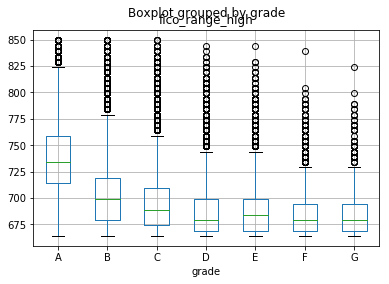

In [23]:
accepted.boxplot(by = 'grade', column = 'fico_range_high')

The change in FICO score may have a large impact on the loans. I attempt to plot the status of the loan against the change in FICO score.

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


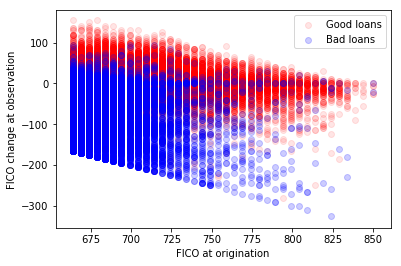

In [20]:
fico_change_loanstat = accepted.loc[accepted.loan_status != 'Current',
                                    ['fico_range_high','last_fico_range_high','loan_status','target']]
# Change in FICO score
fico_change_loanstat['change'] = fico_change_loanstat.last_fico_range_high - fico_change_loanstat.fico_range_high

chargeoff = accepted['target'] == 1

plt.scatter(x = 'fico_range_high', y = 'change', data = fico_change_loanstat[~chargeoff], color = 'r', alpha = 0.1, label = "Good loans")
plt.scatter(x = 'fico_range_high', y = 'change', data = fico_change_loanstat[chargeoff], color = 'b', alpha = 0.2, label = "Bad loans")
plt.legend()
plt.xlabel("FICO at origination")
plt.ylabel("FICO change at observation")


We can easily see that Bad Loans can happen regardless of FICO score at origination. However, loans where the FICO score is lower than 750 is disproportionately more likely to become a bad loan. 

# Modeling
With the status of being a Good or Bad Loan our variable of interest, we can approach this as a classification problem. This is still an exploratory phase so please excuse the haphazard approach.


In [104]:
########
#
# Option 1 - no lookahead
# Many of the features in each observation are recorded as of the last payment date and include
# total principal payment, total interest payment, etc.
# While these data are extremely helpful to classify where a loan is Good or Bad, they are not available at inception
# so I do not include them in the dataset
#
########
def GetXY_1(accepted):
    train = accepted.loc[(accepted['annual_inc'] < salary_limit) | ((accepted['annual_inc'] >= salary_limit) & (accepted['verification_status'] == 'Verified'))]

    train = train[train.loan_status != 'Current']

    lookAheadFeatures = ["out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv",
                         "total_rec_prncp","total_rec_int","total_rec_late_fee",
                         "recoveries","collection_recovery_fee","last_pymnt_d",
                         "last_pymnt_amnt","last_credit_pull_d",
                         "last_fico_range_high","collections_12_mths_ex_med","tot_coll_amt"]

    for feature in lookAheadFeatures:
        if feature in train.columns:
            train = train.drop(feature, axis = 1)

    train['early_cr_line_month'] = -round((train.earliest_cr_line - currentDate) / np.timedelta64(1, 'M'))
    
    # Purpose and employment title will introduce too many variables and may not be that helpful
    train = train.drop(['issue_yr','issue_d', 'purpose','emp_title',
                        'earliest_cr_line','verification_status'], axis = 1)
    train = pd.get_dummies(train, columns = ['term','grade','home_ownership'], drop_first = True)
    X = train.drop(['loan_status', 'target'], axis = 1)
    y = train.target
    
    return X, y


In [83]:
########
# Option 2
# I attempt to replicate the results from Vincenzo
# Source: https://www.kaggle.com/vincepota/predicting-customers-who-will-charge-off/notebook
########

def GetXY_2(accepted):
    features = ['loan_amnt', 
                # 'amt_difference', 
                'term', 'installment', 'grade','emp_length',
                'home_ownership', 'annual_inc',
                'purpose', 'dti', 
                'delinq_2yrs','inq_last_6mths',
                # 'pub_rec_cat', 'acc_ratio', 
                # 'delinq_2yrs_cat', 'inq_last_6mths_cat', 'pub_rec_cat', 'acc_ratio', 
                'open_acc', 'pub_rec', 
                # 'initial_list_status',  
                'loan_status', 'target'
               ]

    train = accepted.loc[(accepted['annual_inc'] < salary_limit) | ((accepted['annual_inc'] >= salary_limit) & (accepted['verification_status'] == 'Verified'))]

    train = train[train.loan_status != 'Current']
    train = train[features]

    train = pd.get_dummies(train, columns = ['term','grade','home_ownership','purpose'], drop_first = True)
    X = train.drop(['loan_status', 'target'], axis = 1)
    y = train.target
    
    return X, y

In [99]:
########
#
# Option 3: Training with lookahead features
# We will reach very high AUC with these features but they are impossible to implement in pracice
#
########

def GetXY_3(accepted):
    train = accepted.loc[(accepted['annual_inc'] < salary_limit) | ((accepted['annual_inc'] >= salary_limit) & (accepted['verification_status'] == 'Verified'))]
    # train = train[train.loan_status != "Current"]

    train['loan_seasoning'] = (train.issue_d - train.last_pymnt_d)/np.timedelta64(1, 'M')
    train['loan_seasoning'] = - train['loan_seasoning']/train['term'].apply(float)

    train['early_cr_line_month'] = -round((train.earliest_cr_line - currentDate) / np.timedelta64(1, 'M'))

    train["pct_" + 'tot_coll_amt'] = train['tot_coll_amt'] / train['annual_inc']

    train['installment_pct'] = train['installment'] * 12 / train['annual_inc'] # installment as a percentage of annual_inc/ 12
    train['fico_change'] = train.fico_range_high - train.last_fico_range_high

    #train = train.drop(money_amnt + ['installment', 'tot_coll_amt'], axis = 1)
    #train = train.drop('ratio_prin', axis = 1)
    train = train.drop('last_fico_range_high', axis = 1)

    train = train.drop(['issue_yr','issue_d', 'purpose','emp_title',
                        'earliest_cr_line','verification_status'], axis = 1)

    train = train.drop('last_credit_pull_d', axis = 1)

    train = train.drop(['last_pymnt_d','last_pymnt_amnt'],axis = 1)

    train = pd.get_dummies(train, columns = ['term','grade','home_ownership'], drop_first = True)
    
    X = train.drop(['loan_status', 'target'], axis = 1)
    y = train.target
    return X, y

We need to create training and testing data. Following Vincezon ([here](https://www.kaggle.com/vincepota/predicting-customers-who-will-charge-off/notebook)), I use Smote to balance the dataset. SMOTE essentially generates new data points in the neighbor of existing observations using a distance metric. I am concerned that this approach may not put any attention on the relationship between each feature and the target variable.

In [105]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
   
sm = SMOTE(random_state = 0, ratio = 1.0) 
X, y = GetXY_1(accepted)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_train_smote, y_train_smote = sm.fit_sample(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)


D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Following Vincenzo's approach, I write a function to train a number of models and record their statistics. I also output the training time of these models and dump them using the joblib package so that I may use them without having to retrain later.

In [77]:
#
# Thanks to Vincenzo Pota for the approach
# https://www.kaggle.com/vincepota/predicting-customers-who-will-charge-off
#
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
import timeit
from sklearn.externals import joblib

def run_models(X_train, y_train, X_test, y_test, date_txt, model_type = 'Non-balanced'):
    
    clfs = {
        'SGDClassifier' : SGDClassifier(loss="log"),
        # Logistic Regression L1 takes more than an hour to train
        'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
        'GaussianNB': GaussianNB(),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=500, max_depth = 3)
    }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):
        start = timeit.default_timer()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        stop = timeit.default_timer()
        print('Run time is', stop - start)
        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         # Precision and Recall using the default threshold of 0.5
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)
        
        # Dump model as file to be used later 
        logistic = joblib.dump(clf, clf_name + '.'+ date_txt + '.pkl')
        np.savetxt(clf_name + "_y_score" + date_txt + ".csv", y_score, delimiter=",")
        
        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix, clfs

D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Run time is 0.0522582002231502
computing SGDClassifier - Balanced 
Run time is 11.983705579143134
computing GradientBoosting - Balanced 
Run time is 0.07172745181014761
computing GaussianNB - Balanced 
Run time is 17.65800105557537
computing RandomForestClassifier - Balanced 


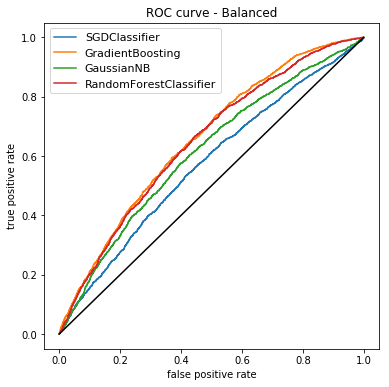

In [106]:
date_txt = '0219_option_1'
models_report, conf_matrix, clfs = run_models(X_train_smote, y_train_smote, X_test_scaled, y_test, date_txt, 'Balanced')

The highest AUC, though still low, is attained by GBM model. Let's take a closer look at  Gradient Boosting results.

(0.0, 1.0)

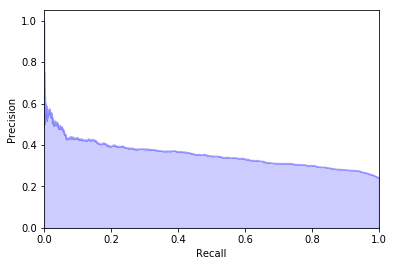

In [107]:
y_score = clfs['GradientBoosting'].predict_proba(X_test_scaled)[:,1]

# Source:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
#
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

Based on the graph above, if we want to reach a recall of 100%, our precision will be around 30%, ie: we may catch all the bad loans, but every time we predict a loan is a bad loan, we may only be accurate about 30% of the time. 

In [108]:
models_report

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,SGDClassifier,0.10,0.57,0.28,0.55,0.37,Balanced
1,GradientBoosting,0.13,0.66,0.41,0.16,0.23,Balanced
2,GaussianNB,0.15,0.61,0.31,0.55,0.40,Balanced
3,RandomForestClassifier,0.18,0.65,0.33,0.59,0.42,Balanced


The value for Precision and Recall may be misleading because it was reported using a default threshold of 0.5.

# Future step

We have constructed a model that can predict whether the loan will be bad loan or not, even though the model does not have stellar performance (AUC around 0.66). I plan to improve this model using 2 approaches:
- Perform additional feature engineering. 
- Further calibrate existing model 

From my experiences, given that the AUC of our rough model is around 0.66, an improvement of 10% to 0.76 would be quite a good achievement already. It will be difficult to improve it to 0.80 or 0.90. 
